In [1]:
#Load car and non car images
import glob
import matplotlib.image as mpimg

images = glob.glob('vehicles/KITTI_extracted/*.png', recursive=True)
images += glob.glob('non-vehicles/**/*.png', recursive=True)
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(mpimg.imread(image))
    else:
        cars.append(mpimg.imread(image))

print('Number of vehicle images loaded:', len(cars))
print('Number of non vehicle images loaded:', len(notcars))

Number of vehicle images loaded: 5966
Number of non vehicle images loaded: 8968


In [2]:
# Import all libraries
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle

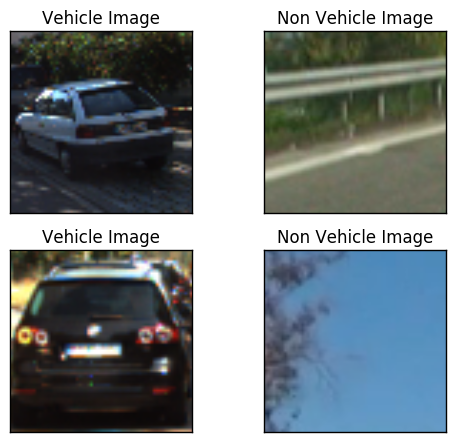

In [3]:
### Plot some random car and non car images from dataset
fig = plt.figure(figsize=(6, 8))

# Create subplots in figure
for r in range(4):
    img = fig.add_subplot(3,2,r+1)
    if r%2==0:
        idx = np.random.randint(1,len(cars))
        plt.imshow((cars[idx]))
        img.set_title("Vehicle Image")
    else:
        idx = np.random.randint(1,len(notcars))
        plt.imshow((notcars[idx]))
        img.set_title("Non Vehicle Image")
        
    img.set_xticks([])
    img.set_yticks([])

plt.show()

In [4]:
# All the helper functions are listed here

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=True, feature_vector=False)
        return features, hog_image
    # Otherwise call with one output without the image
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=False, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of all the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# This function calls bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256),orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        # image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)


        spatial_features = bin_spatial(feature_image, size=spatial_size)

            # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        # Append spatial binning, color hist and hog features into one feature vector
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features


# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop, y_start_stop,
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]

    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    print("Y start and stop: {}".format(y_start_stop))

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def visualize (fig, rows,cols,imgs, titles):
    for i,img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        image_dims=len(img.shape)
        if img_dims < 3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

# Histogram of Oriented Gradients (HOG)

I started off by reading in all the vehicle and non-vehicle images utilizing the glob library in python. I randomly selected couple of images from each category. The code for this step is contained cell #3

In cell #4, helper functions are defined which extracts features using HOG, Spatial Binning, and Color Histogram. The extract_features function iterates over all images passed into the function and extracts features by calling the color_hist, bin_spatial, and the get_hog_features functions. The extract_features function is called for the list of images which contain a car and the list which doesn't, in cell #9. The results of these extracted features for each set of images are then stacked and normalized (using sklearn's StandardScaler method) and then split into training and testing datasets (using sklearn's train_test_split method).



In [6]:
# Search window and heatmap related functions

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32,hist_range=(0, 256), orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features

    spatial_features = bin_spatial(feature_image, size=spatial_size)

    # 4) Compute histogram features

    hist_features = color_hist(feature_image, nbins=hist_bins,bins_range=hist_range)

    # 5) Compute HOG features 
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)    
    else:
        if vis == True:
             hog_features,hog_image = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        else:
             hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # 6) Append features to list
    img_features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    
    # 7) Return feature vector and hog image 
    if vis == True:
        return img_features,hog_image
    else:    
        return img_features
        


# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, vis=False)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows

# Heatmap
def heatmap(heatmap_image, windows):
    #global heatmap_image
    
    for window in hot_windows:
        #print(window[0][1],window[1][1], window[0][0],window[1][0])
        heatmap_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5
        #print(heatmap_image[window[0][1]:window[1][1], window[0][0]:window[1][0]][0][:3])
    
    #plt.imshow(heatmap_image)

    return heatmap_image

# Threshold image
def apply_threshold(heatmap, threshold):
    new_heatmap = np.copy(heatmap)
    # Zero out pixels below the threshold
    new_heatmap[new_heatmap <= threshold] = 0
    # Return thresholded map
    return new_heatmap

# Draw boxes around label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        #print(nonzero[0][0], nonzero[1][0])
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Choice of HOG parameters and architecture

Changing the number of orientations, of pixels per cell and cells per block never gave significantly better results.
So I mainly experimented with several color spaces before settling on HSV (all channels). The next best performing color space was YCrCb.

Ultimately I found best results using HSV 3-channel HOG features plus spatially binned color and histograms of color in the feature vector.

I finalized my approach based on the SVM test accuracy. Coupled with how classification and search window performed, the parameters mentioned below (cell #9) yielded decent results. 

[ 1.  1.  1. ...,  0.  0.  0.]
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
17.99 Seconds to train SVC...
Test Accuracy of SVC =  0.9977
Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 650]
Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 650]
Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 650]
Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 650]
Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 650]
Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 650]


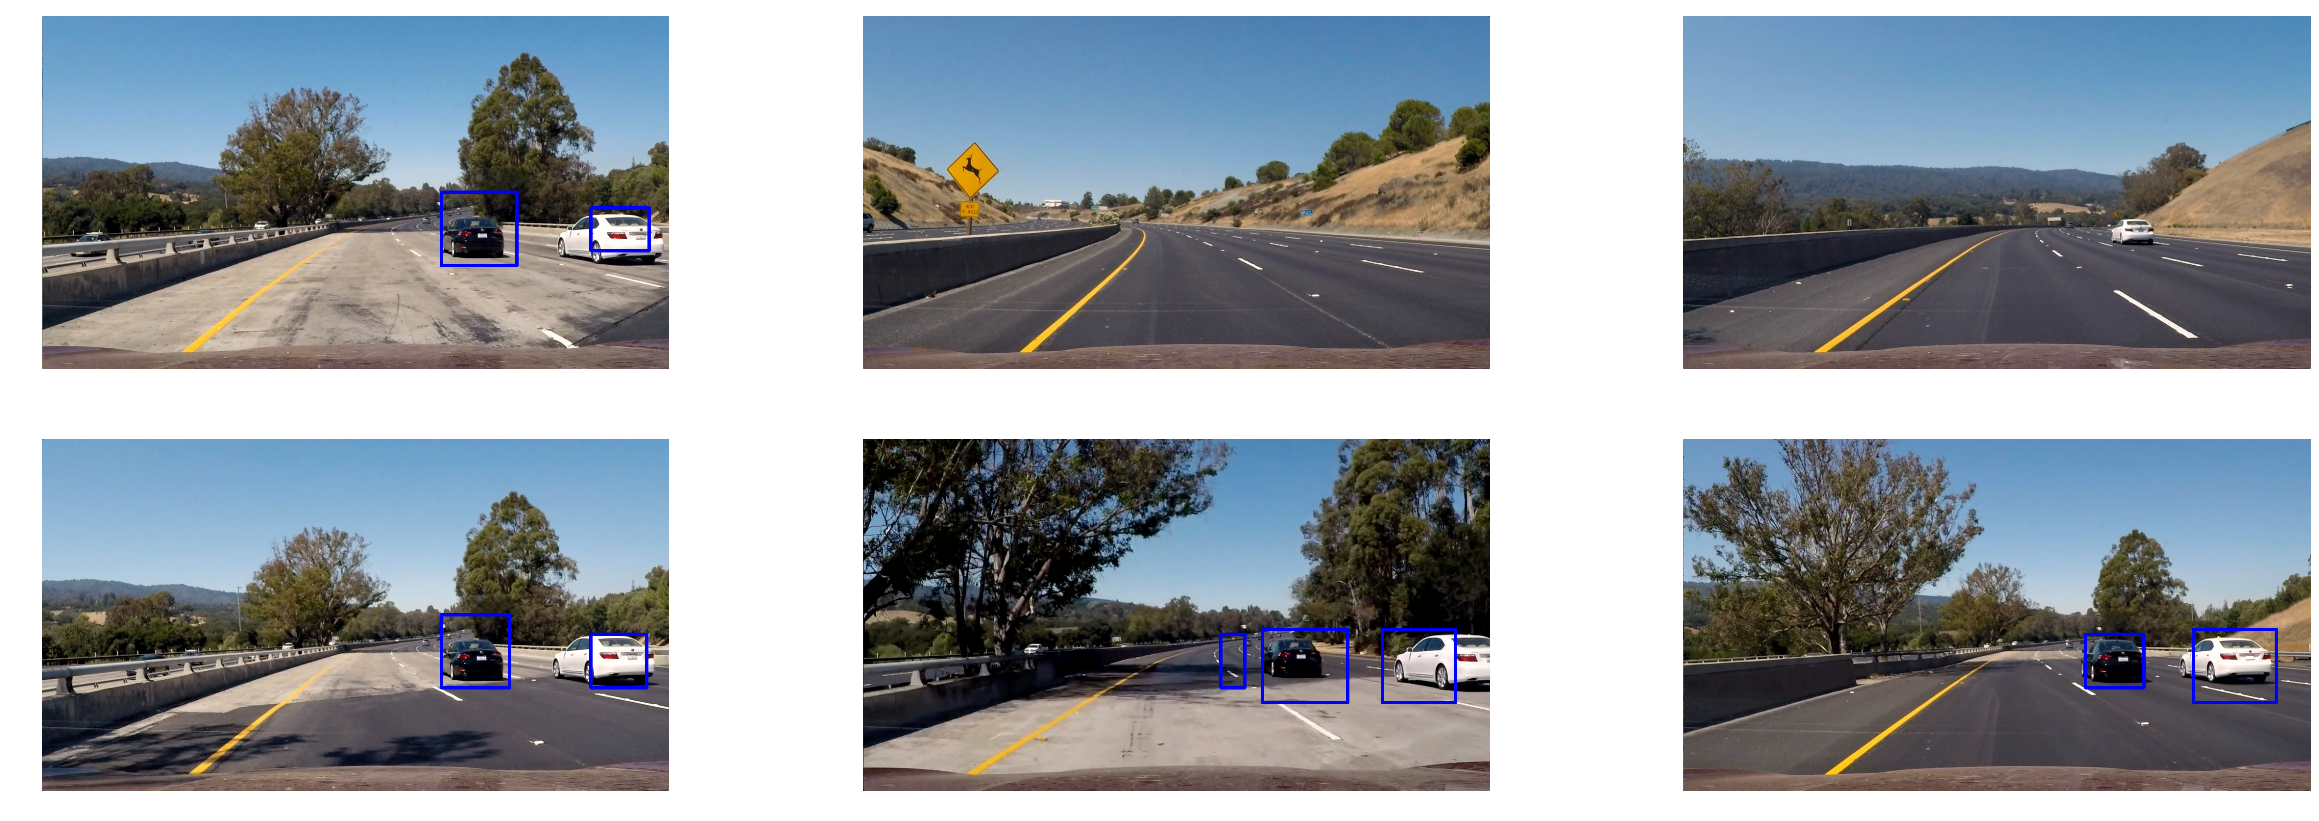

In [9]:
# Pipeline - All the paramters are mentioned here
color_space = 'HSV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
hist_range = (0, 256)
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
# y_start_stop = [None, None]  # Min and max in y to search in slide_window()
#y_start_stop = [50, 100]  # Min and max in y to search in slide_window()
n_samples = 1000
random_idxs = np.random.randint(0,len(cars),n_samples)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]

car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,hist_range=hist_range,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,hist_range=hist_range,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print(y)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=12412)
X_train, y_train = shuffle(X_train, y_train, random_state=2342)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use SVM as the classifier (linear)
svc = LinearSVC()
# Check the training time for the SVC t= time.time()
t = time.time()
# Fit training data
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

#image = mpimg.imread('test_images/test6.jpg')
#draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
images = glob.glob('test_images/*.jpg')
fig = plt.figure(figsize=(30, 10))

for i in range(len(images)):
    
    car_image = mpimg.imread(images[i])
    car_image = car_image.astype(np.float32)/255
    
    # Use combination of different sized windows and x_start_stop and y_start_stop values

    windows1 = slide_window(car_image, x_start_stop=[640, 1280], 
                           y_start_stop=[360,450], 
                           xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
    windows2 = slide_window(car_image, x_start_stop=[640, 1280], 
                           y_start_stop=[360, 450], 
                           xy_window=(120, 120), xy_overlap=(0.75, 0.75))
    
    windows3 = slide_window(car_image, x_start_stop=[640, 1280], 
                           y_start_stop=[400, 514], 
                           xy_window=(140, 140), xy_overlap=(0.75, 0.75))
     
    windows4 = slide_window(car_image, x_start_stop=[640, 1280], 
                           y_start_stop=[450, 650], 
                           xy_window=(140, 140), xy_overlap=(0.75, 0.75))
    
    

    windows = windows1 + windows2 + windows3 + windows4
    

    hot_windows = search_windows(car_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)

    
    heatmap_image = np.zeros_like(mpimg.imread(images[i]))
    heatmap_image = heatmap(heatmap_image, hot_windows)
    
    # Select a threshold value which helps in eliminating false positives
    heatmap_image = apply_threshold(heatmap_image, 5)
    
    #Labels is a 2-tuple, where the first item is an array the size of the heatmap 
    #input image and the second element is the number of labels (cars) found.
    labels = label(heatmap_image)    
    
    # Bounding Box around label
    image = draw_labeled_bboxes(mpimg.imread(images[i]), labels)
    
    # Bounding Boxes around searched vehicle(s)
    window_img_2 = draw_boxes(mpimg.imread(images[i]), hot_windows, color=(0, 0, 255), thick=6)
    

    fig.add_subplot(2,3,i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

# Classifier selection

Once the training and test sets were obtained from extracted features as explained earlier, I used sklearn's Linear Support Vector Classification to train the classifier. This was implemented in cell #9 of the notebook. I was able to get a test accuracy of 99.77%

# Sliding Window Search, choosing the right window size and eliminating false positive.

This part of the algorithm took up quite a bit of trial and error. After a while, it became clear that the window size, restricting the search area by choosing the appropriate x_start, x_stop,y_start,y_stop values and the overlap were important for the entire pipeline to perform well, more important than fine-tuning the classifier. Using a single window (x and y co-ordinates) did not perform well, so I ended up using a combination of different sized windows. Smaller window size were utilized for cars farther down the road and comparatively bigger window sizes near the base. 

I chose a 0.75 overlap for all of them. With smaller window sizes the processing speed went down and did not give much of improvement. I experimented a lot with the different x_start, x_stop, y_start, y_stop positions before finalizing the co-ordinates and realized that even a small change in those values had a big impact on 
a) whether all bounding boxes are being drawn correctly
b) number of false positives

I tried to restrict the windows to the right hand side of the image and that hugely helped bringing down the number of false positives.

In cell #9 of the notebook, the pipeline for individual test images is provided. I initially defined the sliding windows I discuss above. I then call the search_windows function which was defined in the 6th cell of the notebook. This function (based off of the functions we covered in the course) identifies windows in the image(s) where the classifier detects a vehicle.

I then created a heatmap that takes in the bounding boxes per image, and for those regions in a new blank image, adds a constant value for every box. This results in identifying where the classifier predicts the highest probability of a car being present in the image. However, there are still some false positives with this heatmap. As a result, a thresholding operation is carried out to reduce those.

The result of scipy.ndimage.measurements.label() labels the regions that are connected together in the thresholded heatmap. Using this result, a bounding box is drawn around the detected vehicle using the draw_labeled_bboxes function defined in code cell #6. 

# Video Pipeline

The code for the video pipeline is shown directly below in the next cell (cell #) of the notebook.
Essentially similar pipeline as was used for test images was utilized for the video as well.

Couple of additions had to be made -

The results of the above pipeline led to some missing frames and a lot of jittery bounding boxes.

To reduce the jitter I added a weighted moving average, defined by - heatmap_image = prev_heatmap * heatmap_factor + heatmap_image * (1 - heatmap_factor) where the heatmap_factor was set to 0.9 after a bit of experimentation.

The prev_heatmap was stored in a global variable. The new heatmap image was then thresholded again.

This resulted in some good results, but I am still missing detection at some frames. Now, the best solution would have been to go tinker around with sliding window sizes and thresholding value.

Instead I went with 15 frames, for which I added up the heatmaps. I then thresholded this heatmap and again fed it to the weighted moving average equation above.

The results I obtained are now better than before.

In [10]:
### Video pipeline
def process_video(image):
    global prev_heatmap, prev_heatmap_list
    car_image = image.astype(np.float32)/255
    heatmap_factor = 0.9

    
    # Same sliding window co-ordinates for the video.
    windows1 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[360, 450], 
                           xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
    windows2 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[360, 450], 
                           xy_window=(120, 120), xy_overlap=(0.75, 0.75))
    
    windows3 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[400,514], 
                           xy_window=(140, 140), xy_overlap=(0.75, 0.75))
     
    windows4 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[450,600], 
                           xy_window=(160, 160), xy_overlap=(0.75, 0.75))
    
    

    windows = windows1 + windows2 + windows3 + windows4

    hot_windows = search_windows(car_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    
    prev_heatmap_list.append(hot_windows)
    
    # Create heatmap
    heatmap_image = np.zeros_like(car_image)
    
    if len(prev_heatmap_list) > 15:
        prev_heatmap_list.pop(0)
        for prev_hot_windows in prev_heatmap_list:
            for window in prev_hot_windows:
                heatmap_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5
    elif len(prev_heatmap_list) < 15:
        for window in hot_windows:
            heatmap_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5

    
    heatmap_image = cv2.GaussianBlur(heatmap_image,(5,5),0)
    
    heatmap_image = apply_threshold(heatmap_image, 5) 
    
    
    if prev_heatmap == None:
        prev_heatmap = heatmap_image
    else:
        heatmap_image = prev_heatmap * heatmap_factor + heatmap_image * (1 - heatmap_factor)
        heatmap_image = apply_threshold(heatmap_image, 10) 
        prev_heatmap = heatmap_image
    
    
    
    labels = label(heatmap_image)
    image = draw_labeled_bboxes(image, labels)
    
    return image




In [11]:
### Run on test video
from moviepy.editor import VideoFileClip

prev_heatmap = None
prev_heatmap_list = []

#output = 'p5_test.mp4'
output = 'project_output_video1.mp4'

#clip1 = VideoFileClip("./test_video.mp4")
clip1 = VideoFileClip("./project_video.mp4")

output_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]
[MoviePy] >>>> Building video project_output_video1.mp4
[MoviePy] Writing video project_output_video1.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  0%|          | 1/1261 [00:01<32:17,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  0%|          | 2/1261 [00:03<37:06,  1.77s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  0%|          | 3/1261 [00:06<40:07,  1.91s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  0%|          | 4/1261 [00:08<41:42,  1.99s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  0%|          | 5/1261 [00:09<39:15,  1.88s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  0%|          | 6/1261 [00:11<38:14,  1.83s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|          | 7/1261 [00:13<36:22,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|          | 8/1261 [00:14<35:47,  1.71s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|          | 9/1261 [00:16<34:04,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|          | 10/1261 [00:17<34:23,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|          | 11/1261 [00:19<35:06,  1.69s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|          | 12/1261 [00:21<34:37,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|          | 13/1261 [00:22<33:59,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|          | 14/1261 [00:24<33:27,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|          | 15/1261 [00:25<33:05,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|▏         | 16/1261 [00:27<34:53,  1.68s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|▏         | 17/1261 [00:29<34:10,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  1%|▏         | 18/1261 [00:31<33:45,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 19/1261 [00:32<33:27,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 20/1261 [00:34<32:14,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 21/1261 [00:35<31:41,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 22/1261 [00:36<31:17,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 23/1261 [00:38<30:49,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 24/1261 [00:39<30:30,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 25/1261 [00:41<29:53,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 26/1261 [00:42<29:21,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 27/1261 [00:44<29:11,  1.42s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 28/1261 [00:45<29:39,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 29/1261 [00:47<30:09,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 30/1261 [00:48<30:25,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  2%|▏         | 31/1261 [00:49<30:06,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 32/1261 [00:51<30:07,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 33/1261 [00:52<30:02,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 34/1261 [00:54<30:19,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 35/1261 [00:55<30:16,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 36/1261 [00:57<30:35,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 37/1261 [00:58<30:07,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 38/1261 [01:00<31:15,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 39/1261 [01:02<31:04,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 40/1261 [01:03<31:09,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 41/1261 [01:04<30:10,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 42/1261 [01:06<30:29,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 43/1261 [01:08<30:19,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  3%|▎         | 44/1261 [01:09<30:02,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▎         | 45/1261 [01:10<29:47,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▎         | 46/1261 [01:12<30:16,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▎         | 47/1261 [01:14<30:42,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▍         | 48/1261 [01:15<31:25,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▍         | 49/1261 [01:17<31:08,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▍         | 50/1261 [01:18<30:46,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▍         | 51/1261 [01:20<31:25,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▍         | 52/1261 [01:21<30:39,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▍         | 53/1261 [01:23<31:45,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▍         | 54/1261 [01:24<31:38,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▍         | 55/1261 [01:26<32:45,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  4%|▍         | 56/1261 [01:28<32:09,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▍         | 57/1261 [01:29<31:54,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▍         | 58/1261 [01:31<31:05,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▍         | 59/1261 [01:32<31:12,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▍         | 60/1261 [01:34<31:00,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▍         | 61/1261 [01:35<30:59,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▍         | 62/1261 [01:37<30:37,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▍         | 63/1261 [01:39<30:49,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▌         | 64/1261 [01:40<30:48,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▌         | 65/1261 [01:42<30:45,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▌         | 66/1261 [01:43<29:55,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▌         | 67/1261 [01:45<29:51,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▌         | 68/1261 [01:46<30:24,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  5%|▌         | 69/1261 [01:48<30:12,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▌         | 70/1261 [01:49<30:17,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▌         | 71/1261 [01:51<30:26,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▌         | 72/1261 [01:52<30:19,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▌         | 73/1261 [01:54<30:25,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▌         | 74/1261 [01:55<29:41,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▌         | 75/1261 [01:57<29:16,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▌         | 76/1261 [01:58<28:57,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▌         | 77/1261 [02:00<28:44,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▌         | 78/1261 [02:01<29:04,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▋         | 79/1261 [02:03<29:19,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▋         | 80/1261 [02:04<29:19,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  6%|▋         | 81/1261 [02:06<29:47,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 82/1261 [02:07<29:29,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 83/1261 [02:09<29:08,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 84/1261 [02:10<29:44,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 85/1261 [02:12<29:46,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 86/1261 [02:13<29:27,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 87/1261 [02:15<29:22,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 88/1261 [02:16<29:35,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 89/1261 [02:18<29:24,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 90/1261 [02:19<29:25,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 91/1261 [02:21<29:07,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 92/1261 [02:22<28:56,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 93/1261 [02:24<29:14,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  7%|▋         | 94/1261 [02:25<28:55,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 95/1261 [02:27<28:57,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 96/1261 [02:28<29:36,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 97/1261 [02:30<29:32,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 98/1261 [02:31<29:54,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 99/1261 [02:33<30:01,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 100/1261 [02:34<29:51,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 101/1261 [02:36<29:36,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 102/1261 [02:37<29:32,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 103/1261 [02:39<29:18,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 104/1261 [02:41<30:50,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 105/1261 [02:42<31:29,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 106/1261 [02:44<32:16,  1.68s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  8%|▊         | 107/1261 [02:46<31:28,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▊         | 108/1261 [02:47<30:51,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▊         | 109/1261 [02:49<32:26,  1.69s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▊         | 110/1261 [02:51<33:22,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▉         | 111/1261 [02:53<33:43,  1.76s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▉         | 112/1261 [02:54<32:22,  1.69s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▉         | 113/1261 [02:56<31:38,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▉         | 114/1261 [02:58<32:07,  1.68s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▉         | 115/1261 [02:59<32:09,  1.68s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▉         | 116/1261 [03:01<31:52,  1.67s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▉         | 117/1261 [03:03<34:08,  1.79s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▉         | 118/1261 [03:05<34:03,  1.79s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


  9%|▉         | 119/1261 [03:07<33:53,  1.78s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|▉         | 120/1261 [03:08<33:03,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|▉         | 121/1261 [03:10<33:10,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|▉         | 122/1261 [03:12<33:59,  1.79s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|▉         | 123/1261 [03:13<32:00,  1.69s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|▉         | 124/1261 [03:15<32:16,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|▉         | 125/1261 [03:17<31:40,  1.67s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|▉         | 126/1261 [03:18<31:05,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|█         | 127/1261 [03:20<30:10,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|█         | 128/1261 [03:21<31:03,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|█         | 129/1261 [03:23<30:27,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|█         | 130/1261 [03:25<29:36,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|█         | 131/1261 [03:26<29:03,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 10%|█         | 132/1261 [03:28<29:18,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█         | 133/1261 [03:29<28:56,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█         | 134/1261 [03:31<29:11,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█         | 135/1261 [03:32<29:05,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█         | 136/1261 [03:34<28:42,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█         | 137/1261 [03:35<29:09,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█         | 138/1261 [03:37<28:29,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█         | 139/1261 [03:38<28:16,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█         | 140/1261 [03:40<28:26,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█         | 141/1261 [03:41<28:30,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█▏        | 142/1261 [03:43<28:29,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█▏        | 143/1261 [03:45<29:19,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█▏        | 144/1261 [03:46<29:12,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 11%|█▏        | 145/1261 [03:48<28:44,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 146/1261 [03:49<28:23,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 147/1261 [03:51<28:00,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 148/1261 [03:52<28:21,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 149/1261 [03:54<28:39,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 150/1261 [03:55<28:36,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 151/1261 [03:57<27:52,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 152/1261 [03:58<28:10,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 153/1261 [04:00<28:18,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 154/1261 [04:01<27:42,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 155/1261 [04:03<27:36,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 156/1261 [04:04<27:26,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 12%|█▏        | 157/1261 [04:06<27:01,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 158/1261 [04:07<27:18,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 159/1261 [04:09<26:52,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 160/1261 [04:10<27:51,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 161/1261 [04:12<27:55,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 162/1261 [04:13<27:48,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 163/1261 [04:15<27:22,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 164/1261 [04:16<27:44,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 165/1261 [04:18<28:26,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 166/1261 [04:20<29:06,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 167/1261 [04:21<29:06,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 168/1261 [04:23<28:42,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 169/1261 [04:24<28:38,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 13%|█▎        | 170/1261 [04:26<27:49,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▎        | 171/1261 [04:27<28:34,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▎        | 172/1261 [04:29<27:57,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▎        | 173/1261 [04:30<28:38,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▍        | 174/1261 [04:32<28:03,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▍        | 175/1261 [04:33<27:31,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▍        | 176/1261 [04:35<27:08,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▍        | 177/1261 [04:36<26:38,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▍        | 178/1261 [04:38<26:51,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▍        | 179/1261 [04:39<26:36,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▍        | 180/1261 [04:41<26:22,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▍        | 181/1261 [04:42<26:19,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 14%|█▍        | 182/1261 [04:44<26:04,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▍        | 183/1261 [04:45<25:48,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▍        | 184/1261 [04:46<25:49,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▍        | 185/1261 [04:48<25:49,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▍        | 186/1261 [04:49<25:40,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▍        | 187/1261 [04:51<26:18,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▍        | 188/1261 [04:52<26:18,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▍        | 189/1261 [04:54<26:02,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▌        | 190/1261 [04:55<26:10,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▌        | 191/1261 [04:57<26:08,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▌        | 192/1261 [04:58<26:32,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▌        | 193/1261 [05:00<26:10,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▌        | 194/1261 [05:01<26:14,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 15%|█▌        | 195/1261 [05:03<26:20,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▌        | 196/1261 [05:04<26:53,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▌        | 197/1261 [05:06<26:43,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▌        | 198/1261 [05:07<26:51,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▌        | 199/1261 [05:09<27:34,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▌        | 200/1261 [05:11<28:17,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▌        | 201/1261 [05:12<27:51,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▌        | 202/1261 [05:14<27:20,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▌        | 203/1261 [05:15<28:57,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▌        | 204/1261 [05:17<28:56,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▋        | 205/1261 [05:19<29:51,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▋        | 206/1261 [05:20<28:57,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▋        | 207/1261 [05:22<28:33,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 16%|█▋        | 208/1261 [05:24<27:40,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 209/1261 [05:25<27:34,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 210/1261 [05:27<28:00,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 211/1261 [05:29<32:03,  1.83s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 212/1261 [05:31<31:43,  1.81s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 213/1261 [05:33<30:51,  1.77s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 214/1261 [05:34<29:43,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 215/1261 [05:36<28:51,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 216/1261 [05:37<29:01,  1.67s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 217/1261 [05:40<32:57,  1.89s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 218/1261 [05:42<33:16,  1.91s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 219/1261 [05:44<34:16,  1.97s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 17%|█▋        | 220/1261 [05:46<35:41,  2.06s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 221/1261 [05:48<36:38,  2.11s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 222/1261 [05:51<37:32,  2.17s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 223/1261 [05:53<38:42,  2.24s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 224/1261 [05:55<35:45,  2.07s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 225/1261 [05:56<32:25,  1.88s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 226/1261 [05:58<30:14,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 227/1261 [05:59<28:26,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 228/1261 [06:00<27:26,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 229/1261 [06:02<26:44,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 230/1261 [06:04<27:07,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 231/1261 [06:05<26:26,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 232/1261 [06:06<25:48,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 18%|█▊        | 233/1261 [06:08<25:49,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▊        | 234/1261 [06:09<25:55,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▊        | 235/1261 [06:11<25:30,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▊        | 236/1261 [06:12<25:10,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▉        | 237/1261 [06:14<25:45,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▉        | 238/1261 [06:16<26:11,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▉        | 239/1261 [06:17<25:38,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▉        | 240/1261 [06:18<25:25,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▉        | 241/1261 [06:20<25:51,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▉        | 242/1261 [06:22<26:03,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▉        | 243/1261 [06:23<27:53,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▉        | 244/1261 [06:25<28:29,  1.68s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 19%|█▉        | 245/1261 [06:27<27:44,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|█▉        | 246/1261 [06:28<27:01,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|█▉        | 247/1261 [06:30<26:35,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|█▉        | 248/1261 [06:31<26:25,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|█▉        | 249/1261 [06:33<26:04,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|█▉        | 250/1261 [06:34<25:26,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|█▉        | 251/1261 [06:36<25:06,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|█▉        | 252/1261 [06:37<25:12,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|██        | 253/1261 [06:39<25:09,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|██        | 254/1261 [06:40<25:18,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|██        | 255/1261 [06:42<26:22,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|██        | 256/1261 [06:44<26:11,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|██        | 257/1261 [06:45<25:37,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 20%|██        | 258/1261 [06:47<25:26,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██        | 259/1261 [06:48<25:32,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██        | 260/1261 [06:49<25:04,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██        | 261/1261 [06:51<24:41,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██        | 262/1261 [06:52<24:26,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██        | 263/1261 [06:54<24:58,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██        | 264/1261 [06:56<25:50,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██        | 265/1261 [06:57<25:50,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██        | 266/1261 [06:59<25:40,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██        | 267/1261 [07:00<25:55,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██▏       | 268/1261 [07:02<25:53,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██▏       | 269/1261 [07:04<26:28,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██▏       | 270/1261 [07:05<25:47,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 21%|██▏       | 271/1261 [07:07<27:07,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 272/1261 [07:09<27:40,  1.68s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 273/1261 [07:10<26:36,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 274/1261 [07:12<27:36,  1.68s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 275/1261 [07:14<29:46,  1.81s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 276/1261 [07:16<31:57,  1.95s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 277/1261 [07:18<29:59,  1.83s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 278/1261 [07:20<29:57,  1.83s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 279/1261 [07:22<32:29,  1.99s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 280/1261 [07:24<30:35,  1.87s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 281/1261 [07:25<30:26,  1.86s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 282/1261 [07:28<32:30,  1.99s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 22%|██▏       | 283/1261 [07:30<31:38,  1.94s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 284/1261 [07:31<29:15,  1.80s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 285/1261 [07:33<27:54,  1.72s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 286/1261 [07:34<27:20,  1.68s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 287/1261 [07:36<26:24,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 288/1261 [07:37<25:47,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 289/1261 [07:39<25:19,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 290/1261 [07:40<24:44,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 291/1261 [07:42<24:57,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 292/1261 [07:43<25:21,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 293/1261 [07:45<25:05,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 294/1261 [07:46<25:00,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 295/1261 [07:48<25:24,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 23%|██▎       | 296/1261 [07:50<25:20,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▎       | 297/1261 [07:51<24:50,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▎       | 298/1261 [07:53<24:49,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▎       | 299/1261 [07:54<25:38,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▍       | 300/1261 [07:56<25:02,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▍       | 301/1261 [07:58<25:31,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▍       | 302/1261 [08:00<28:10,  1.76s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▍       | 303/1261 [08:01<27:28,  1.72s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▍       | 304/1261 [08:03<26:31,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▍       | 305/1261 [08:04<26:09,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▍       | 306/1261 [08:06<26:18,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▍       | 307/1261 [08:08<26:57,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 24%|██▍       | 308/1261 [08:10<27:01,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▍       | 309/1261 [08:11<26:10,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▍       | 310/1261 [08:13<27:57,  1.76s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▍       | 311/1261 [08:15<28:42,  1.81s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▍       | 312/1261 [08:18<32:33,  2.06s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▍       | 313/1261 [08:20<33:14,  2.10s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▍       | 314/1261 [08:21<30:09,  1.91s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▍       | 315/1261 [08:23<27:45,  1.76s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▌       | 316/1261 [08:24<26:06,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▌       | 317/1261 [08:26<25:06,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▌       | 318/1261 [08:27<24:21,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▌       | 319/1261 [08:29<25:55,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▌       | 320/1261 [08:30<24:52,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 25%|██▌       | 321/1261 [08:33<29:43,  1.90s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▌       | 322/1261 [08:35<30:36,  1.96s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▌       | 323/1261 [08:37<28:15,  1.81s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▌       | 324/1261 [08:38<26:33,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▌       | 325/1261 [08:39<25:08,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▌       | 326/1261 [08:42<28:50,  1.85s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▌       | 327/1261 [08:44<28:14,  1.81s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▌       | 328/1261 [08:45<26:24,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▌       | 329/1261 [08:47<25:48,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▌       | 330/1261 [08:48<25:48,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▌       | 331/1261 [08:50<25:29,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▋       | 332/1261 [08:52<25:42,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▋       | 333/1261 [08:53<24:46,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 26%|██▋       | 334/1261 [08:54<24:02,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 335/1261 [08:56<23:39,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 336/1261 [08:57<23:22,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 337/1261 [08:59<22:59,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 338/1261 [09:00<22:34,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 339/1261 [09:02<22:25,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 340/1261 [09:03<22:28,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 341/1261 [09:05<22:59,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 342/1261 [09:06<23:35,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 343/1261 [09:08<23:37,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 344/1261 [09:10<23:32,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 345/1261 [09:11<23:25,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 27%|██▋       | 346/1261 [09:12<23:02,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 347/1261 [09:14<22:32,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 348/1261 [09:16<23:43,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 349/1261 [09:17<24:23,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 350/1261 [09:19<24:15,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 351/1261 [09:20<23:55,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 352/1261 [09:22<24:39,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 353/1261 [09:24<24:16,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 354/1261 [09:25<23:38,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 355/1261 [09:27<23:23,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 356/1261 [09:28<23:28,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 357/1261 [09:30<23:01,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 358/1261 [09:31<23:04,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 28%|██▊       | 359/1261 [09:33<23:18,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▊       | 360/1261 [09:34<23:05,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▊       | 361/1261 [09:36<22:58,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▊       | 362/1261 [09:37<22:36,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▉       | 363/1261 [09:39<22:24,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▉       | 364/1261 [09:40<22:36,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▉       | 365/1261 [09:42<22:15,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▉       | 366/1261 [09:43<22:14,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▉       | 367/1261 [09:45<22:42,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▉       | 368/1261 [09:46<22:45,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▉       | 369/1261 [09:48<22:52,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▉       | 370/1261 [09:50<22:45,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 29%|██▉       | 371/1261 [09:51<22:17,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|██▉       | 372/1261 [09:52<22:01,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|██▉       | 373/1261 [09:54<21:50,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|██▉       | 374/1261 [09:55<21:39,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|██▉       | 375/1261 [09:57<21:41,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|██▉       | 376/1261 [09:58<22:29,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|██▉       | 377/1261 [10:00<22:08,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|██▉       | 378/1261 [10:01<22:15,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|███       | 379/1261 [10:03<21:52,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|███       | 380/1261 [10:04<21:37,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|███       | 381/1261 [10:06<21:29,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|███       | 382/1261 [10:07<21:08,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|███       | 383/1261 [10:09<22:01,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 30%|███       | 384/1261 [10:10<21:57,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███       | 385/1261 [10:12<22:12,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███       | 386/1261 [10:13<21:48,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███       | 387/1261 [10:15<21:52,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███       | 388/1261 [10:16<21:53,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███       | 389/1261 [10:18<21:47,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███       | 390/1261 [10:19<21:51,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███       | 391/1261 [10:21<22:51,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███       | 392/1261 [10:23<26:10,  1.81s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███       | 393/1261 [10:25<27:00,  1.87s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███       | 394/1261 [10:27<25:35,  1.77s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███▏      | 395/1261 [10:29<24:31,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███▏      | 396/1261 [10:30<23:17,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 31%|███▏      | 397/1261 [10:31<22:28,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 398/1261 [10:33<22:19,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 399/1261 [10:34<22:16,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 400/1261 [10:36<21:47,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 401/1261 [10:37<21:24,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 402/1261 [10:39<21:10,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 403/1261 [10:40<21:04,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 404/1261 [10:42<20:59,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 405/1261 [10:43<21:00,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 406/1261 [10:45<20:53,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 407/1261 [10:46<20:37,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 408/1261 [10:48<20:48,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 32%|███▏      | 409/1261 [10:49<20:52,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 410/1261 [10:50<20:43,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 411/1261 [10:52<20:41,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 412/1261 [10:53<20:37,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 413/1261 [10:55<20:31,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 414/1261 [10:56<20:36,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 415/1261 [10:58<21:34,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 416/1261 [11:00<21:30,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 417/1261 [11:01<21:22,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 418/1261 [11:03<21:26,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 419/1261 [11:04<21:27,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 420/1261 [11:06<21:31,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 421/1261 [11:07<21:10,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 33%|███▎      | 422/1261 [11:09<21:45,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▎      | 423/1261 [11:10<21:48,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▎      | 424/1261 [11:12<21:59,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▎      | 425/1261 [11:13<21:24,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▍      | 426/1261 [11:15<21:37,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▍      | 427/1261 [11:17<21:44,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▍      | 428/1261 [11:18<21:42,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▍      | 429/1261 [11:20<21:44,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▍      | 430/1261 [11:21<21:43,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▍      | 431/1261 [11:23<21:14,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▍      | 432/1261 [11:24<21:02,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▍      | 433/1261 [11:26<20:55,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▍      | 434/1261 [11:27<20:32,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 34%|███▍      | 435/1261 [11:29<20:35,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▍      | 436/1261 [11:30<20:30,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▍      | 437/1261 [11:32<20:47,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▍      | 438/1261 [11:33<20:33,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▍      | 439/1261 [11:35<20:09,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▍      | 440/1261 [11:36<20:04,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▍      | 441/1261 [11:37<19:59,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▌      | 442/1261 [11:39<19:49,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▌      | 443/1261 [11:40<19:41,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▌      | 444/1261 [11:42<19:43,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▌      | 445/1261 [11:43<19:33,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▌      | 446/1261 [11:45<19:44,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 35%|███▌      | 447/1261 [11:46<19:40,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▌      | 448/1261 [11:48<19:39,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▌      | 449/1261 [11:49<19:27,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▌      | 450/1261 [11:50<19:26,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▌      | 451/1261 [11:52<19:33,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▌      | 452/1261 [11:53<19:37,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▌      | 453/1261 [11:55<19:34,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▌      | 454/1261 [11:56<19:31,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▌      | 455/1261 [11:58<19:32,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▌      | 456/1261 [11:59<19:27,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▌      | 457/1261 [12:01<20:11,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▋      | 458/1261 [12:02<20:02,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▋      | 459/1261 [12:04<20:26,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 36%|███▋      | 460/1261 [12:05<20:02,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 461/1261 [12:07<20:53,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 462/1261 [12:09<21:23,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 463/1261 [12:10<21:09,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 464/1261 [12:12<20:56,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 465/1261 [12:13<20:20,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 466/1261 [12:15<20:07,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 467/1261 [12:16<20:52,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 468/1261 [12:18<22:09,  1.68s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 469/1261 [12:20<22:36,  1.71s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 470/1261 [12:22<23:51,  1.81s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 471/1261 [12:25<25:56,  1.97s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 37%|███▋      | 472/1261 [12:26<25:26,  1.93s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 473/1261 [12:29<26:25,  2.01s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 474/1261 [12:30<24:51,  1.89s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 475/1261 [12:32<25:33,  1.95s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 476/1261 [12:34<24:07,  1.84s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 477/1261 [12:36<23:08,  1.77s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 478/1261 [12:37<22:07,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 479/1261 [12:38<21:00,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 480/1261 [12:40<21:03,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 481/1261 [12:42<20:57,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 482/1261 [12:43<20:27,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 483/1261 [12:45<20:22,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 484/1261 [12:46<20:42,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 38%|███▊      | 485/1261 [12:48<20:31,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▊      | 486/1261 [12:49<20:01,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▊      | 487/1261 [12:51<19:56,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▊      | 488/1261 [12:53<21:22,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▉      | 489/1261 [12:55<22:28,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▉      | 490/1261 [12:56<21:51,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▉      | 491/1261 [12:58<21:23,  1.67s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▉      | 492/1261 [13:00<21:11,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▉      | 493/1261 [13:01<21:53,  1.71s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▉      | 494/1261 [13:03<21:04,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▉      | 495/1261 [13:04<20:03,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▉      | 496/1261 [13:06<19:38,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▉      | 497/1261 [13:07<19:40,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 39%|███▉      | 498/1261 [13:09<20:00,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|███▉      | 499/1261 [13:11<19:32,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|███▉      | 500/1261 [13:12<19:18,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|███▉      | 501/1261 [13:13<19:07,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|███▉      | 502/1261 [13:15<20:22,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|███▉      | 503/1261 [13:17<20:55,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|███▉      | 504/1261 [13:19<20:44,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|████      | 505/1261 [13:20<20:53,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|████      | 506/1261 [13:22<20:22,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|████      | 507/1261 [13:24<20:29,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|████      | 508/1261 [13:25<20:07,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|████      | 509/1261 [13:27<19:32,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 40%|████      | 510/1261 [13:28<19:21,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████      | 511/1261 [13:29<18:47,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████      | 512/1261 [13:31<19:05,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████      | 513/1261 [13:33<19:01,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████      | 514/1261 [13:34<19:19,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████      | 515/1261 [13:36<19:09,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████      | 516/1261 [13:37<19:00,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████      | 517/1261 [13:39<18:38,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████      | 518/1261 [13:40<18:37,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████      | 519/1261 [13:42<18:47,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████      | 520/1261 [13:43<18:51,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████▏     | 521/1261 [13:45<18:55,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████▏     | 522/1261 [13:46<18:54,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 41%|████▏     | 523/1261 [13:48<19:32,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 524/1261 [13:50<19:43,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 525/1261 [13:51<19:23,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 526/1261 [13:53<19:16,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 527/1261 [13:54<19:15,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 528/1261 [13:56<19:13,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 529/1261 [13:58<19:18,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 530/1261 [13:59<19:11,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 531/1261 [14:01<18:39,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 532/1261 [14:02<18:26,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 533/1261 [14:03<18:08,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 534/1261 [14:05<17:50,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 42%|████▏     | 535/1261 [14:06<17:40,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 536/1261 [14:08<17:45,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 537/1261 [14:09<17:58,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 538/1261 [14:11<18:14,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 539/1261 [14:12<18:13,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 540/1261 [14:14<18:00,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 541/1261 [14:15<18:04,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 542/1261 [14:17<18:19,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 543/1261 [14:19<18:33,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 544/1261 [14:20<18:35,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 545/1261 [14:22<18:31,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 546/1261 [14:23<18:26,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 547/1261 [14:25<18:17,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 43%|████▎     | 548/1261 [14:26<18:31,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▎     | 549/1261 [14:28<18:20,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▎     | 550/1261 [14:29<18:08,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▎     | 551/1261 [14:31<17:51,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▍     | 552/1261 [14:32<17:39,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▍     | 553/1261 [14:34<18:00,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▍     | 554/1261 [14:35<18:04,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▍     | 555/1261 [14:37<18:04,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▍     | 556/1261 [14:39<18:24,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▍     | 557/1261 [14:40<18:49,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▍     | 558/1261 [14:42<18:34,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▍     | 559/1261 [14:43<18:36,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▍     | 560/1261 [14:45<18:11,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 44%|████▍     | 561/1261 [14:46<17:50,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▍     | 562/1261 [14:48<17:38,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▍     | 563/1261 [14:49<17:34,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▍     | 564/1261 [14:51<18:13,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▍     | 565/1261 [14:53<18:08,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▍     | 566/1261 [14:54<18:34,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▍     | 567/1261 [14:56<18:22,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▌     | 568/1261 [14:57<18:03,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▌     | 569/1261 [14:59<18:26,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▌     | 570/1261 [15:01<18:24,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▌     | 571/1261 [15:02<18:07,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▌     | 572/1261 [15:04<17:42,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 45%|████▌     | 573/1261 [15:05<17:20,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▌     | 574/1261 [15:07<17:27,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▌     | 575/1261 [15:08<17:08,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▌     | 576/1261 [15:10<17:27,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▌     | 577/1261 [15:11<17:16,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▌     | 578/1261 [15:13<16:59,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▌     | 579/1261 [15:14<17:01,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▌     | 580/1261 [15:16<18:32,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▌     | 581/1261 [15:18<18:11,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▌     | 582/1261 [15:19<17:56,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▌     | 583/1261 [15:21<18:02,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▋     | 584/1261 [15:22<17:55,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▋     | 585/1261 [15:24<18:14,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 46%|████▋     | 586/1261 [15:26<17:49,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 587/1261 [15:27<17:30,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 588/1261 [15:29<17:32,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 589/1261 [15:30<17:23,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 590/1261 [15:32<17:25,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 591/1261 [15:33<17:22,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 592/1261 [15:35<17:10,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 593/1261 [15:36<16:46,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 594/1261 [15:38<16:38,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 595/1261 [15:39<16:41,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 596/1261 [15:41<16:46,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 597/1261 [15:43<18:11,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 47%|████▋     | 598/1261 [15:44<17:41,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 599/1261 [15:46<17:46,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 600/1261 [15:47<17:33,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 601/1261 [15:49<16:59,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 602/1261 [15:50<16:58,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 603/1261 [15:52<16:36,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 604/1261 [15:53<16:24,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 605/1261 [15:55<16:28,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 606/1261 [15:56<16:30,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 607/1261 [15:58<16:49,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 608/1261 [15:59<16:52,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 609/1261 [16:01<16:44,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 610/1261 [16:03<16:40,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 48%|████▊     | 611/1261 [16:04<16:54,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▊     | 612/1261 [16:06<16:33,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▊     | 613/1261 [16:07<16:34,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▊     | 614/1261 [16:09<16:42,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▉     | 615/1261 [16:10<16:53,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▉     | 616/1261 [16:12<16:55,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▉     | 617/1261 [16:13<16:50,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▉     | 618/1261 [16:15<16:40,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▉     | 619/1261 [16:17<16:36,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▉     | 620/1261 [16:18<16:43,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▉     | 621/1261 [16:20<16:52,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▉     | 622/1261 [16:21<17:05,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▉     | 623/1261 [16:23<17:11,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 49%|████▉     | 624/1261 [16:25<17:02,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|████▉     | 625/1261 [16:26<16:48,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|████▉     | 626/1261 [16:28<16:26,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|████▉     | 627/1261 [16:29<16:08,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|████▉     | 628/1261 [16:31<16:06,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|████▉     | 629/1261 [16:32<16:14,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|████▉     | 630/1261 [16:34<16:21,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|█████     | 631/1261 [16:35<16:35,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|█████     | 632/1261 [16:37<16:32,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|█████     | 633/1261 [16:38<16:07,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|█████     | 634/1261 [16:40<16:31,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|█████     | 635/1261 [16:42<16:22,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 50%|█████     | 636/1261 [16:43<16:15,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████     | 637/1261 [16:45<16:27,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████     | 638/1261 [16:47<16:37,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████     | 639/1261 [16:48<16:45,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████     | 640/1261 [16:50<16:52,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████     | 641/1261 [16:51<16:17,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████     | 642/1261 [16:53<15:50,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████     | 643/1261 [16:54<15:20,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████     | 644/1261 [16:56<15:24,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████     | 645/1261 [16:57<15:18,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████     | 646/1261 [16:59<15:25,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████▏    | 647/1261 [17:00<15:32,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████▏    | 648/1261 [17:02<15:55,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 51%|█████▏    | 649/1261 [17:03<15:57,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 650/1261 [17:05<15:58,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 651/1261 [17:07<16:18,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 652/1261 [17:08<16:26,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 653/1261 [17:10<16:40,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 654/1261 [17:12<16:21,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 655/1261 [17:13<15:54,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 656/1261 [17:15<15:54,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 657/1261 [17:17<17:25,  1.73s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 658/1261 [17:18<16:44,  1.67s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 659/1261 [17:20<16:18,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 660/1261 [17:21<16:28,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 661/1261 [17:23<16:09,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 52%|█████▏    | 662/1261 [17:25<16:07,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 663/1261 [17:26<15:50,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 664/1261 [17:28<15:34,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 665/1261 [17:29<15:30,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 666/1261 [17:31<15:25,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 667/1261 [17:33<15:51,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 668/1261 [17:34<15:40,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 669/1261 [17:36<15:26,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 670/1261 [17:37<15:22,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 671/1261 [17:39<15:10,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 672/1261 [17:40<14:59,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 673/1261 [17:42<15:00,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 53%|█████▎    | 674/1261 [17:43<14:47,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▎    | 675/1261 [17:45<14:45,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▎    | 676/1261 [17:46<14:55,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▎    | 677/1261 [17:48<14:51,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▍    | 678/1261 [17:49<14:46,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▍    | 679/1261 [17:51<14:37,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▍    | 680/1261 [17:52<14:30,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▍    | 681/1261 [17:54<14:19,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▍    | 682/1261 [17:55<14:14,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▍    | 683/1261 [17:57<14:06,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▍    | 684/1261 [17:58<14:08,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▍    | 685/1261 [17:59<14:09,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▍    | 686/1261 [18:01<14:17,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 54%|█████▍    | 687/1261 [18:03<14:26,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▍    | 688/1261 [18:04<14:23,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▍    | 689/1261 [18:05<14:07,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▍    | 690/1261 [18:07<14:18,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▍    | 691/1261 [18:09<14:41,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▍    | 692/1261 [18:10<14:47,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▍    | 693/1261 [18:12<15:00,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▌    | 694/1261 [18:14<14:56,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▌    | 695/1261 [18:15<14:34,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▌    | 696/1261 [18:16<14:16,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▌    | 697/1261 [18:18<14:02,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▌    | 698/1261 [18:19<13:54,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 55%|█████▌    | 699/1261 [18:21<13:47,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▌    | 700/1261 [18:22<13:47,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▌    | 701/1261 [18:24<13:38,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▌    | 702/1261 [18:25<13:32,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▌    | 703/1261 [18:27<13:34,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▌    | 704/1261 [18:28<13:38,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▌    | 705/1261 [18:30<13:38,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▌    | 706/1261 [18:31<13:58,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▌    | 707/1261 [18:33<14:13,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▌    | 708/1261 [18:34<14:05,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▌    | 709/1261 [18:36<14:08,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▋    | 710/1261 [18:37<14:01,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▋    | 711/1261 [18:39<13:53,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 56%|█████▋    | 712/1261 [18:40<14:03,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 713/1261 [18:42<14:06,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 714/1261 [18:43<14:00,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 715/1261 [18:45<13:56,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 716/1261 [18:47<14:21,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 717/1261 [18:48<14:21,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 718/1261 [18:50<14:10,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 719/1261 [18:51<14:23,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 720/1261 [18:53<14:18,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 721/1261 [18:55<13:58,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 722/1261 [18:56<13:41,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 723/1261 [18:57<13:33,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 724/1261 [18:59<13:42,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 57%|█████▋    | 725/1261 [19:01<13:33,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 726/1261 [19:02<13:27,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 727/1261 [19:03<13:15,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 728/1261 [19:05<13:07,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 729/1261 [19:06<13:00,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 730/1261 [19:08<13:05,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 731/1261 [19:09<13:05,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 732/1261 [19:11<13:02,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 733/1261 [19:12<12:59,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 734/1261 [19:14<12:55,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 735/1261 [19:15<13:32,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 736/1261 [19:17<13:56,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 58%|█████▊    | 737/1261 [19:19<13:48,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▊    | 738/1261 [19:20<13:28,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▊    | 739/1261 [19:22<13:21,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▊    | 740/1261 [19:23<13:11,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▉    | 741/1261 [19:25<13:08,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▉    | 742/1261 [19:26<13:00,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▉    | 743/1261 [19:28<12:52,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▉    | 744/1261 [19:29<13:06,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▉    | 745/1261 [19:31<13:16,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▉    | 746/1261 [19:32<13:06,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▉    | 747/1261 [19:34<13:00,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▉    | 748/1261 [19:35<12:40,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▉    | 749/1261 [19:37<12:36,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 59%|█████▉    | 750/1261 [19:38<12:29,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|█████▉    | 751/1261 [19:40<12:24,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|█████▉    | 752/1261 [19:41<12:19,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|█████▉    | 753/1261 [19:42<12:23,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|█████▉    | 754/1261 [19:44<12:19,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|█████▉    | 755/1261 [19:45<12:22,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|█████▉    | 756/1261 [19:47<12:36,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|██████    | 757/1261 [19:49<13:48,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|██████    | 758/1261 [19:51<13:33,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|██████    | 759/1261 [19:52<14:15,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|██████    | 760/1261 [19:54<14:26,  1.73s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|██████    | 761/1261 [19:57<15:54,  1.91s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 60%|██████    | 762/1261 [19:58<14:57,  1.80s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████    | 763/1261 [20:00<14:11,  1.71s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████    | 764/1261 [20:01<13:40,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████    | 765/1261 [20:03<13:18,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████    | 766/1261 [20:04<13:15,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████    | 767/1261 [20:06<13:49,  1.68s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████    | 768/1261 [20:09<17:14,  2.10s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████    | 769/1261 [20:12<19:50,  2.42s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████    | 770/1261 [20:17<25:11,  3.08s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████    | 771/1261 [20:20<25:16,  3.10s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████    | 772/1261 [20:23<23:39,  2.90s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████▏   | 773/1261 [20:24<20:38,  2.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████▏   | 774/1261 [20:26<18:19,  2.26s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 61%|██████▏   | 775/1261 [20:28<16:59,  2.10s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 776/1261 [20:29<15:44,  1.95s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 777/1261 [20:31<14:39,  1.82s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 778/1261 [20:33<14:47,  1.84s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 779/1261 [20:34<14:48,  1.84s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 780/1261 [20:36<14:07,  1.76s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 781/1261 [20:38<13:43,  1.72s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 782/1261 [20:39<13:50,  1.73s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 783/1261 [20:41<14:01,  1.76s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 784/1261 [20:43<13:35,  1.71s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 785/1261 [20:44<13:14,  1.67s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 786/1261 [20:46<12:51,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 787/1261 [20:47<12:39,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 62%|██████▏   | 788/1261 [20:49<12:38,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 789/1261 [20:51<12:36,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 790/1261 [20:52<12:17,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 791/1261 [20:54<12:04,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 792/1261 [20:55<11:56,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 793/1261 [20:57<11:55,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 794/1261 [20:58<12:02,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 795/1261 [21:00<12:01,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 796/1261 [21:01<11:57,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 797/1261 [21:03<12:01,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 798/1261 [21:04<12:09,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 799/1261 [21:06<11:56,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 63%|██████▎   | 800/1261 [21:08<12:06,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▎   | 801/1261 [21:09<12:00,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▎   | 802/1261 [21:11<12:29,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▎   | 803/1261 [21:13<12:24,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▍   | 804/1261 [21:14<12:20,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▍   | 805/1261 [21:16<12:00,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▍   | 806/1261 [21:17<11:46,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▍   | 807/1261 [21:19<11:28,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▍   | 808/1261 [21:20<11:37,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▍   | 809/1261 [21:22<11:23,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▍   | 810/1261 [21:23<11:22,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▍   | 811/1261 [21:25<11:16,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▍   | 812/1261 [21:26<11:08,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 64%|██████▍   | 813/1261 [21:28<11:36,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▍   | 814/1261 [21:29<11:25,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▍   | 815/1261 [21:31<11:38,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▍   | 816/1261 [21:32<11:28,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▍   | 817/1261 [21:34<11:17,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▍   | 818/1261 [21:35<11:02,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▍   | 819/1261 [21:37<11:07,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▌   | 820/1261 [21:38<11:04,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▌   | 821/1261 [21:40<11:09,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▌   | 822/1261 [21:41<11:01,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▌   | 823/1261 [21:43<10:55,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▌   | 824/1261 [21:44<10:50,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 65%|██████▌   | 825/1261 [21:46<10:44,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▌   | 826/1261 [21:47<10:40,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▌   | 827/1261 [21:49<10:39,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▌   | 828/1261 [21:50<10:43,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▌   | 829/1261 [21:52<10:47,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▌   | 830/1261 [21:53<10:57,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▌   | 831/1261 [21:55<11:23,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▌   | 832/1261 [21:57<11:17,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▌   | 833/1261 [21:59<12:17,  1.72s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▌   | 834/1261 [22:01<13:17,  1.87s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▌   | 835/1261 [22:03<14:22,  2.02s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▋   | 836/1261 [22:06<14:54,  2.10s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▋   | 837/1261 [22:08<15:17,  2.16s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 66%|██████▋   | 838/1261 [22:10<14:21,  2.04s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 839/1261 [22:11<13:15,  1.88s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 840/1261 [22:13<13:00,  1.85s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 841/1261 [22:15<13:12,  1.89s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 842/1261 [22:17<12:50,  1.84s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 843/1261 [22:19<13:34,  1.95s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 844/1261 [22:21<14:31,  2.09s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 845/1261 [22:23<14:34,  2.10s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 846/1261 [22:25<14:06,  2.04s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 847/1261 [22:27<13:44,  1.99s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 848/1261 [22:29<14:06,  2.05s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 849/1261 [22:31<13:34,  1.98s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 850/1261 [22:33<13:43,  2.00s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 67%|██████▋   | 851/1261 [22:36<15:00,  2.20s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 852/1261 [22:37<13:39,  2.00s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 853/1261 [22:39<12:52,  1.89s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 854/1261 [22:41<12:06,  1.79s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 855/1261 [22:42<11:20,  1.68s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 856/1261 [22:43<10:51,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 857/1261 [22:45<10:46,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 858/1261 [22:47<11:03,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 859/1261 [22:48<10:46,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 860/1261 [22:50<10:33,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 861/1261 [22:51<10:14,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 862/1261 [22:53<10:02,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 68%|██████▊   | 863/1261 [22:54<09:53,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▊   | 864/1261 [22:56<09:48,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▊   | 865/1261 [22:57<09:41,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▊   | 866/1261 [22:59<09:45,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▉   | 867/1261 [23:00<10:02,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▉   | 868/1261 [23:02<10:08,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▉   | 869/1261 [23:03<09:54,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▉   | 870/1261 [23:05<09:53,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▉   | 871/1261 [23:06<09:37,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▉   | 872/1261 [23:08<09:27,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▉   | 873/1261 [23:09<09:25,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▉   | 874/1261 [23:10<09:20,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▉   | 875/1261 [23:12<09:14,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 69%|██████▉   | 876/1261 [23:13<09:21,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|██████▉   | 877/1261 [23:15<09:31,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|██████▉   | 878/1261 [23:16<09:24,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|██████▉   | 879/1261 [23:18<09:23,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|██████▉   | 880/1261 [23:19<09:23,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|██████▉   | 881/1261 [23:21<09:53,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|██████▉   | 882/1261 [23:23<09:41,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|███████   | 883/1261 [23:24<09:32,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|███████   | 884/1261 [23:25<09:26,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|███████   | 885/1261 [23:27<09:19,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|███████   | 886/1261 [23:28<09:14,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|███████   | 887/1261 [23:30<09:13,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|███████   | 888/1261 [23:31<09:08,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 70%|███████   | 889/1261 [23:33<09:04,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████   | 890/1261 [23:34<09:03,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████   | 891/1261 [23:36<09:00,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████   | 892/1261 [23:37<08:58,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████   | 893/1261 [23:39<09:40,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████   | 894/1261 [23:41<10:01,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████   | 895/1261 [23:42<10:02,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████   | 896/1261 [23:44<09:44,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████   | 897/1261 [23:45<09:26,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████   | 898/1261 [23:47<09:22,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████▏  | 899/1261 [23:48<09:15,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████▏  | 900/1261 [23:50<09:42,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 71%|███████▏  | 901/1261 [23:52<09:27,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 902/1261 [23:53<09:21,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 903/1261 [23:55<09:08,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 904/1261 [23:56<09:25,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 905/1261 [23:58<09:10,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 906/1261 [23:59<08:59,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 907/1261 [24:01<09:19,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 908/1261 [24:03<09:06,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 909/1261 [24:04<08:57,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 910/1261 [24:05<08:50,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 911/1261 [24:07<09:06,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 912/1261 [24:09<08:54,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 913/1261 [24:10<08:43,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 72%|███████▏  | 914/1261 [24:12<08:37,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 915/1261 [24:13<08:35,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 916/1261 [24:14<08:30,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 917/1261 [24:16<08:32,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 918/1261 [24:17<08:31,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 919/1261 [24:19<08:27,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 920/1261 [24:20<08:33,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 921/1261 [24:22<08:34,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 922/1261 [24:23<08:26,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 923/1261 [24:25<08:21,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 924/1261 [24:26<08:13,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 925/1261 [24:28<08:09,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 73%|███████▎  | 926/1261 [24:29<08:08,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▎  | 927/1261 [24:31<08:06,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▎  | 928/1261 [24:32<08:07,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▎  | 929/1261 [24:34<08:05,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▍  | 930/1261 [24:35<07:59,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▍  | 931/1261 [24:37<08:04,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▍  | 932/1261 [24:38<08:05,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▍  | 933/1261 [24:40<08:04,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▍  | 934/1261 [24:41<08:17,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▍  | 935/1261 [24:43<08:16,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▍  | 936/1261 [24:44<08:08,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▍  | 937/1261 [24:46<07:55,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▍  | 938/1261 [24:47<07:49,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 74%|███████▍  | 939/1261 [24:48<07:46,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▍  | 940/1261 [24:50<07:51,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▍  | 941/1261 [24:51<07:55,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▍  | 942/1261 [24:53<08:31,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▍  | 943/1261 [24:55<08:20,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▍  | 944/1261 [24:56<08:27,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▍  | 945/1261 [24:58<08:31,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▌  | 946/1261 [25:00<08:31,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▌  | 947/1261 [25:02<09:01,  1.73s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▌  | 948/1261 [25:03<08:50,  1.69s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▌  | 949/1261 [25:05<08:39,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▌  | 950/1261 [25:07<08:55,  1.72s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▌  | 951/1261 [25:08<08:34,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 75%|███████▌  | 952/1261 [25:10<08:14,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▌  | 953/1261 [25:11<07:53,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▌  | 954/1261 [25:13<07:43,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▌  | 955/1261 [25:14<07:37,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▌  | 956/1261 [25:16<07:32,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▌  | 957/1261 [25:17<07:26,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▌  | 958/1261 [25:18<07:24,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▌  | 959/1261 [25:20<07:25,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▌  | 960/1261 [25:21<07:21,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▌  | 961/1261 [25:23<07:21,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▋  | 962/1261 [25:24<07:21,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▋  | 963/1261 [25:26<07:15,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 76%|███████▋  | 964/1261 [25:27<07:12,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 965/1261 [25:29<07:17,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 966/1261 [25:30<07:18,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 967/1261 [25:32<07:27,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 968/1261 [25:33<07:32,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 969/1261 [25:35<07:21,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 970/1261 [25:36<07:13,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 971/1261 [25:38<07:22,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 972/1261 [25:40<07:24,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 973/1261 [25:42<08:08,  1.69s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 974/1261 [25:44<09:06,  1.90s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 975/1261 [25:46<09:32,  2.00s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 976/1261 [25:48<09:08,  1.92s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 77%|███████▋  | 977/1261 [25:49<08:28,  1.79s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 978/1261 [25:51<07:58,  1.69s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 979/1261 [25:52<07:39,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 980/1261 [25:54<07:23,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 981/1261 [25:55<07:22,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 982/1261 [25:57<07:18,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 983/1261 [25:59<07:23,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 984/1261 [26:00<07:22,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 985/1261 [26:02<07:14,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 986/1261 [26:03<07:06,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 987/1261 [26:05<07:01,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 988/1261 [26:06<06:55,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 78%|███████▊  | 989/1261 [26:08<07:06,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▊  | 990/1261 [26:09<07:01,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▊  | 991/1261 [26:11<06:50,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▊  | 992/1261 [26:12<06:45,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▊  | 993/1261 [26:14<06:44,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▉  | 994/1261 [26:15<06:42,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▉  | 995/1261 [26:17<06:53,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▉  | 996/1261 [26:19<07:06,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▉  | 997/1261 [26:20<06:57,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▉  | 998/1261 [26:22<07:04,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▉  | 999/1261 [26:24<06:58,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▉  | 1000/1261 [26:25<06:52,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▉  | 1001/1261 [26:27<06:48,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 79%|███████▉  | 1002/1261 [26:28<06:37,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|███████▉  | 1003/1261 [26:30<06:42,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|███████▉  | 1004/1261 [26:31<06:43,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|███████▉  | 1005/1261 [26:33<06:43,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|███████▉  | 1006/1261 [26:35<06:50,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|███████▉  | 1007/1261 [26:36<06:45,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|███████▉  | 1008/1261 [26:38<06:42,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|████████  | 1009/1261 [26:39<06:45,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|████████  | 1010/1261 [26:41<06:50,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|████████  | 1011/1261 [26:43<06:37,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|████████  | 1012/1261 [26:44<06:37,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|████████  | 1013/1261 [26:46<06:31,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|████████  | 1014/1261 [26:47<06:28,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 80%|████████  | 1015/1261 [26:49<06:19,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████  | 1016/1261 [26:50<06:17,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████  | 1017/1261 [26:52<06:30,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████  | 1018/1261 [26:53<06:22,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████  | 1019/1261 [26:55<06:12,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████  | 1020/1261 [26:56<06:08,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████  | 1021/1261 [26:58<06:06,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████  | 1022/1261 [26:59<06:02,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████  | 1023/1261 [27:01<06:03,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████  | 1024/1261 [27:03<06:05,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████▏ | 1025/1261 [27:04<06:05,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████▏ | 1026/1261 [27:06<05:58,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 81%|████████▏ | 1027/1261 [27:07<06:15,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1028/1261 [27:09<06:18,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1029/1261 [27:11<06:12,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1030/1261 [27:12<06:02,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1031/1261 [27:14<06:06,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1032/1261 [27:16<06:34,  1.72s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1033/1261 [27:18<06:46,  1.78s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1034/1261 [27:20<07:04,  1.87s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1035/1261 [27:21<06:41,  1.78s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1036/1261 [27:23<06:12,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1037/1261 [27:24<05:52,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1038/1261 [27:25<05:35,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1039/1261 [27:27<05:33,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 82%|████████▏ | 1040/1261 [27:29<05:58,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1041/1261 [27:31<06:24,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1042/1261 [27:32<06:02,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1043/1261 [27:34<05:41,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1044/1261 [27:35<05:26,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1045/1261 [27:37<05:31,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1046/1261 [27:38<05:33,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1047/1261 [27:40<05:15,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1048/1261 [27:41<05:04,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1049/1261 [27:42<05:01,  1.42s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1050/1261 [27:44<05:25,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1051/1261 [27:46<05:37,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 83%|████████▎ | 1052/1261 [27:48<05:38,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▎ | 1053/1261 [27:49<05:29,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▎ | 1054/1261 [27:51<05:29,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▎ | 1055/1261 [27:52<05:26,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▎ | 1056/1261 [27:54<05:10,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▍ | 1057/1261 [27:55<05:16,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▍ | 1058/1261 [27:57<05:00,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▍ | 1059/1261 [27:58<05:07,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▍ | 1060/1261 [28:00<05:27,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▍ | 1061/1261 [28:02<05:45,  1.73s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▍ | 1062/1261 [28:04<05:58,  1.80s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▍ | 1063/1261 [28:05<05:38,  1.71s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▍ | 1064/1261 [28:07<05:21,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 84%|████████▍ | 1065/1261 [28:08<05:12,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▍ | 1066/1261 [28:10<05:03,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▍ | 1067/1261 [28:11<04:53,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▍ | 1068/1261 [28:13<04:43,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▍ | 1069/1261 [28:14<04:36,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▍ | 1070/1261 [28:15<04:32,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▍ | 1071/1261 [28:17<04:33,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▌ | 1072/1261 [28:18<04:28,  1.42s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▌ | 1073/1261 [28:20<04:24,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▌ | 1074/1261 [28:21<04:18,  1.38s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▌ | 1075/1261 [28:22<04:25,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▌ | 1076/1261 [28:24<04:45,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▌ | 1077/1261 [28:26<04:32,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 85%|████████▌ | 1078/1261 [28:27<04:47,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▌ | 1079/1261 [28:29<04:54,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▌ | 1080/1261 [28:31<04:41,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▌ | 1081/1261 [28:32<04:35,  1.53s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▌ | 1082/1261 [28:33<04:28,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▌ | 1083/1261 [28:35<04:19,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▌ | 1084/1261 [28:36<04:11,  1.42s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▌ | 1085/1261 [28:38<04:13,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▌ | 1086/1261 [28:39<04:14,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▌ | 1087/1261 [28:41<04:16,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▋ | 1088/1261 [28:42<04:11,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▋ | 1089/1261 [28:43<04:07,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 86%|████████▋ | 1090/1261 [28:45<04:04,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1091/1261 [28:46<04:02,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1092/1261 [28:48<03:58,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1093/1261 [28:49<03:57,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1094/1261 [28:50<03:53,  1.40s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1095/1261 [28:52<03:51,  1.39s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1096/1261 [28:53<03:47,  1.38s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1097/1261 [28:55<03:46,  1.38s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1098/1261 [28:56<03:45,  1.39s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1099/1261 [28:58<03:52,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1100/1261 [28:59<03:55,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1101/1261 [29:00<03:53,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1102/1261 [29:02<03:46,  1.42s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 87%|████████▋ | 1103/1261 [29:03<03:43,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1104/1261 [29:05<03:44,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1105/1261 [29:06<03:44,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1106/1261 [29:08<03:40,  1.42s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1107/1261 [29:09<03:39,  1.42s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1108/1261 [29:10<03:36,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1109/1261 [29:12<03:36,  1.42s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1110/1261 [29:13<03:33,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1111/1261 [29:15<03:42,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1112/1261 [29:17<03:57,  1.60s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1113/1261 [29:18<03:52,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1114/1261 [29:20<03:42,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 88%|████████▊ | 1115/1261 [29:21<03:36,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▊ | 1116/1261 [29:23<03:37,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▊ | 1117/1261 [29:24<03:31,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▊ | 1118/1261 [29:25<03:26,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▊ | 1119/1261 [29:27<03:22,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▉ | 1120/1261 [29:28<03:25,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▉ | 1121/1261 [29:30<03:24,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▉ | 1122/1261 [29:31<03:29,  1.51s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▉ | 1123/1261 [29:33<03:24,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▉ | 1124/1261 [29:34<03:20,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▉ | 1125/1261 [29:35<03:13,  1.42s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▉ | 1126/1261 [29:37<03:09,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▉ | 1127/1261 [29:38<03:09,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 89%|████████▉ | 1128/1261 [29:40<03:06,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|████████▉ | 1129/1261 [29:41<03:05,  1.40s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|████████▉ | 1130/1261 [29:42<03:01,  1.39s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|████████▉ | 1131/1261 [29:44<03:07,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|████████▉ | 1132/1261 [29:46<03:18,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|████████▉ | 1133/1261 [29:47<03:12,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|████████▉ | 1134/1261 [29:49<03:05,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|█████████ | 1135/1261 [29:50<03:00,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|█████████ | 1136/1261 [29:51<02:56,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|█████████ | 1137/1261 [29:53<02:53,  1.40s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|█████████ | 1138/1261 [29:54<02:51,  1.40s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|█████████ | 1139/1261 [29:55<02:51,  1.40s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|█████████ | 1140/1261 [29:57<02:54,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 90%|█████████ | 1141/1261 [29:59<03:04,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████ | 1142/1261 [30:00<03:07,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████ | 1143/1261 [30:02<02:57,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████ | 1144/1261 [30:03<02:52,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████ | 1145/1261 [30:05<02:51,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████ | 1146/1261 [30:06<02:47,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████ | 1147/1261 [30:08<02:47,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████ | 1148/1261 [30:09<02:49,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████ | 1149/1261 [30:11<02:55,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████ | 1150/1261 [30:12<02:48,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████▏| 1151/1261 [30:14<02:42,  1.48s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████▏| 1152/1261 [30:15<02:46,  1.52s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 91%|█████████▏| 1153/1261 [30:17<02:39,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1154/1261 [30:18<02:36,  1.46s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1155/1261 [30:19<02:34,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1156/1261 [30:21<02:32,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1157/1261 [30:22<02:30,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1158/1261 [30:24<02:26,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1159/1261 [30:25<02:27,  1.45s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1160/1261 [30:27<02:30,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1161/1261 [30:29<02:36,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1162/1261 [30:30<02:35,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1163/1261 [30:32<02:33,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1164/1261 [30:33<02:28,  1.54s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1165/1261 [30:35<02:22,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 92%|█████████▏| 1166/1261 [30:36<02:16,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1167/1261 [30:37<02:12,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1168/1261 [30:39<02:09,  1.39s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1169/1261 [30:40<02:06,  1.37s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1170/1261 [30:41<02:10,  1.43s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1171/1261 [30:43<02:23,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1172/1261 [30:45<02:19,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1173/1261 [30:46<02:16,  1.55s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1174/1261 [30:48<02:09,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1175/1261 [30:49<02:04,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1176/1261 [30:50<01:59,  1.41s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1177/1261 [30:52<01:56,  1.38s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1178/1261 [30:53<01:53,  1.36s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 93%|█████████▎| 1179/1261 [30:54<01:51,  1.35s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▎| 1180/1261 [30:56<01:49,  1.36s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▎| 1181/1261 [30:57<01:48,  1.35s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▎| 1182/1261 [30:58<01:46,  1.35s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▍| 1183/1261 [31:00<01:44,  1.34s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▍| 1184/1261 [31:01<01:43,  1.34s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▍| 1185/1261 [31:02<01:42,  1.35s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▍| 1186/1261 [31:04<01:40,  1.33s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▍| 1187/1261 [31:05<01:39,  1.35s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▍| 1188/1261 [31:07<01:38,  1.35s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▍| 1189/1261 [31:08<01:38,  1.36s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▍| 1190/1261 [31:09<01:36,  1.36s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 94%|█████████▍| 1191/1261 [31:11<01:35,  1.37s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▍| 1192/1261 [31:12<01:33,  1.36s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▍| 1193/1261 [31:13<01:31,  1.34s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▍| 1194/1261 [31:15<01:32,  1.38s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▍| 1195/1261 [31:17<01:38,  1.49s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▍| 1196/1261 [31:18<01:37,  1.50s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▍| 1197/1261 [31:19<01:34,  1.47s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▌| 1198/1261 [31:21<01:30,  1.44s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▌| 1199/1261 [31:22<01:28,  1.42s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▌| 1200/1261 [31:24<01:25,  1.40s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▌| 1201/1261 [31:26<01:34,  1.58s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▌| 1202/1261 [31:27<01:35,  1.62s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▌| 1203/1261 [31:29<01:30,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 95%|█████████▌| 1204/1261 [31:30<01:29,  1.57s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▌| 1205/1261 [31:32<01:27,  1.56s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▌| 1206/1261 [31:34<01:29,  1.63s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▌| 1207/1261 [31:35<01:27,  1.61s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▌| 1208/1261 [31:37<01:29,  1.69s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▌| 1209/1261 [31:39<01:29,  1.72s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▌| 1210/1261 [31:41<01:27,  1.71s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▌| 1211/1261 [31:42<01:21,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▌| 1212/1261 [31:44<01:21,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▌| 1213/1261 [31:45<01:19,  1.65s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▋| 1214/1261 [31:47<01:18,  1.67s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▋| 1215/1261 [31:49<01:16,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 96%|█████████▋| 1216/1261 [31:51<01:16,  1.71s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1217/1261 [31:52<01:14,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1218/1261 [31:54<01:12,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1219/1261 [31:55<01:08,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1220/1261 [31:57<01:05,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1221/1261 [31:58<01:03,  1.59s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1222/1261 [32:00<01:04,  1.64s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1223/1261 [32:02<01:04,  1.70s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1224/1261 [32:04<01:01,  1.67s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1225/1261 [32:06<01:03,  1.78s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1226/1261 [32:07<01:00,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1227/1261 [32:09<01:00,  1.77s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1228/1261 [32:11<00:56,  1.71s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 97%|█████████▋| 1229/1261 [32:12<00:53,  1.66s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1230/1261 [32:14<00:51,  1.67s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1231/1261 [32:16<00:50,  1.69s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1232/1261 [32:18<00:49,  1.72s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1233/1261 [32:19<00:48,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1234/1261 [32:21<00:46,  1.73s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1235/1261 [32:23<00:45,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1236/1261 [32:25<00:43,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1237/1261 [32:26<00:41,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1238/1261 [32:28<00:39,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1239/1261 [32:30<00:38,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1240/1261 [32:32<00:36,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1241/1261 [32:33<00:34,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 98%|█████████▊| 1242/1261 [32:35<00:33,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▊| 1243/1261 [32:37<00:31,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▊| 1244/1261 [32:39<00:29,  1.76s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▊| 1245/1261 [32:40<00:27,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▉| 1246/1261 [32:42<00:26,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▉| 1247/1261 [32:44<00:24,  1.78s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▉| 1248/1261 [32:46<00:23,  1.79s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▉| 1249/1261 [32:47<00:21,  1.78s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▉| 1250/1261 [32:49<00:19,  1.77s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▉| 1251/1261 [32:51<00:17,  1.76s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▉| 1252/1261 [32:53<00:15,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▉| 1253/1261 [32:54<00:13,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


 99%|█████████▉| 1254/1261 [32:56<00:12,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


100%|█████████▉| 1255/1261 [32:58<00:10,  1.74s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


100%|█████████▉| 1256/1261 [33:00<00:08,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


100%|█████████▉| 1257/1261 [33:01<00:07,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


100%|█████████▉| 1258/1261 [33:03<00:05,  1.75s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


100%|█████████▉| 1259/1261 [33:05<00:03,  1.76s/it]

Y start and stop: [360, 450]
Y start and stop: [360, 450]
Y start and stop: [400, 514]
Y start and stop: [450, 600]


100%|█████████▉| 1260/1261 [33:07<00:01,  1.76s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video1.mp4 

CPU times: user 57min 37s, sys: 1min 24s, total: 59min 1s
Wall time: 33min 8s


# Reflections

Again, just like P4, most of the time was spent tuning the parameters and finding what works well with each other.
The bounding boxes are still jittery in the video although I was glad I could get rid of the false positives.
The pipleine is prone to failing in worse weather/lighting conditions.

Just like my observation with P4, I believe a deep learning approach could have served the purpose better.